# EDA

Before moving on to modeling, here's some valuable exploration to help better understand the data we're working with. The charts and manipulations help us build a general framework for our modeling approach moving forward

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

blue = '#2b5772'
red = '#ff6b65'
green = '#00c2b1'
gray = '#bac8d3'

globe = pd.read_pickle('sample.pkl')
subset = pd.read_pickle('least_vars.pkl')

## Gloabl Sea Surface Temp

In [29]:
globe['timestamp'] = pd.to_datetime(globe[['year', 'month', 'day']])
newfoundland = globe[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

### Global vs Single Locaiton Trends

To illustrate the variance in sea surface temperature across the globe versus within a single set of coordinates, notice the thickness of the respective lines.

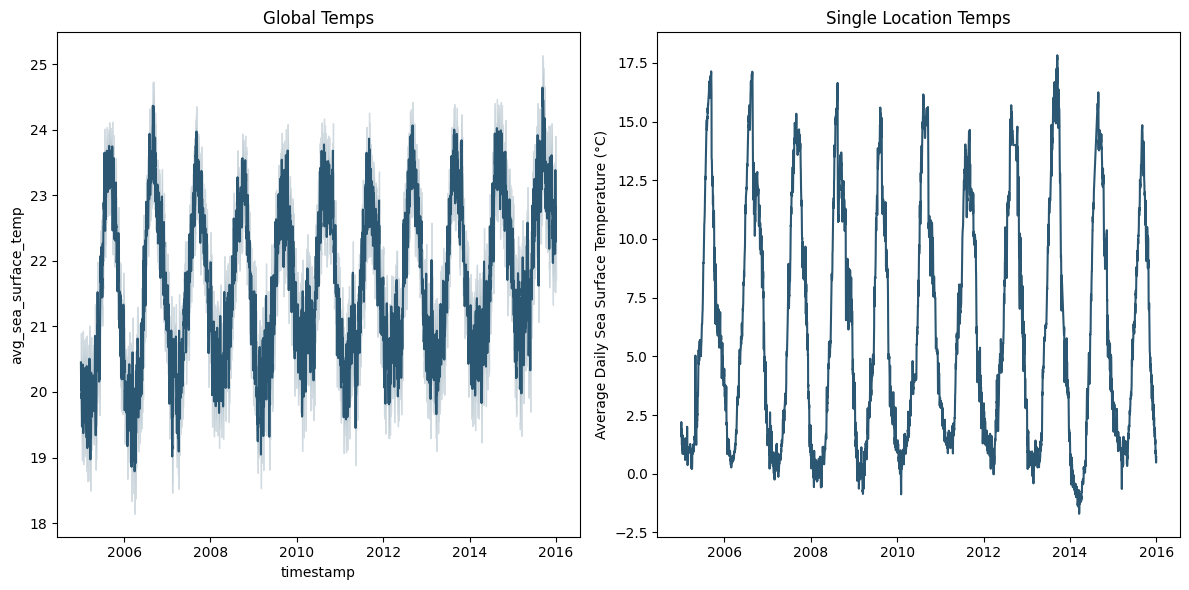

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=globe, x='timestamp', y='avg_sea_surface_temp', ax=ax[0], color=blue)
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland, x='timestamp', y='avg_sea_surface_temp', ax=ax[1], color=blue)
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

#### Potential Predictors of Sea Surface Temperature

We want to consider using additional variables outside of a sequence of the predictor, so lets look at a heatmap

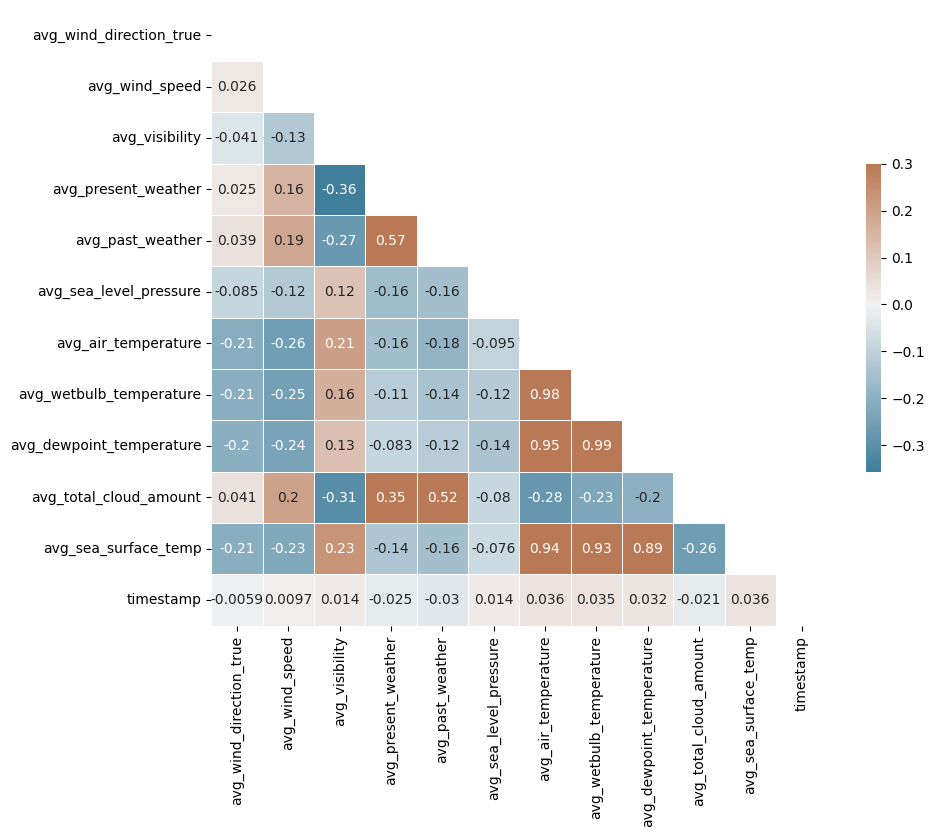

In [4]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = globe.drop(columns=['year', 'month', 'day', 'longitude', 'latitude']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)

plt.figure(figsize=(10, 8))  # Adjust the size of the figure as per your requirement
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']))
scaled = pd.DataFrame(scaler.transform(globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp'])), columns=globe.drop(columns=['year', 'month', 'day', 'latitude', 'longitude', 'timestamp']).columns)
scaled['timestamp'] = globe['timestamp']

newfoundland_scaled = scaled[(globe['latitude'] == 46.4) & (globe['longitude'] == -48.4)].sort_values('timestamp', ascending=True)

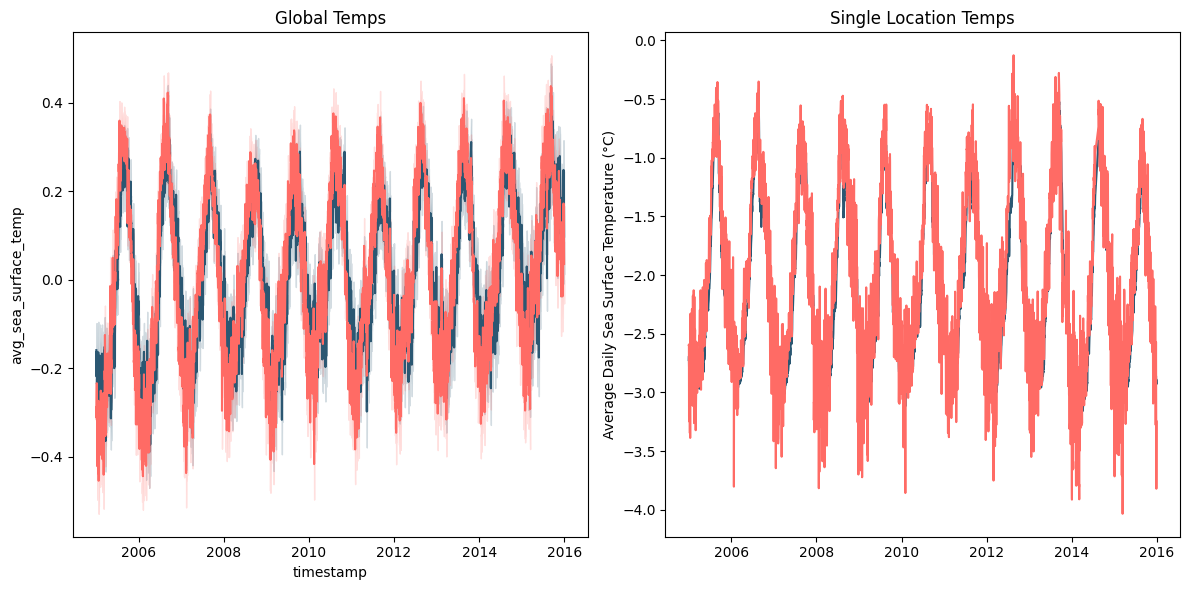

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(data=scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[0], color=blue)
sns.lineplot(data=scaled, x='timestamp', y='avg_air_temperature', ax=ax[0], color=red)
ax[0].set_title('Global Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_sea_surface_temp', ax=ax[1], color=blue)
sns.lineplot(data=newfoundland_scaled, x='timestamp', y='avg_air_temperature', ax=ax[1], color=red)
ax[1].set_title('Single Location Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

You can see globally that the blue (sea temp) is preceeded by orange (air temp), this along with the heatmap would suggest it is a good covariate

### The Problem

Ultimately, it will be useful to model individual locations, rather than the global average. However, there are missing values throughout timestamps in certain locations

In [34]:
globe['Lat, Long'] = globe['latitude'].astype(str) + ', ' + globe['longitude'].astype(str)

In [35]:
example = globe[(globe['Lat, Long'] == '53.8, -3.5') | (globe['Lat, Long'] == '54.4, 11.1')]

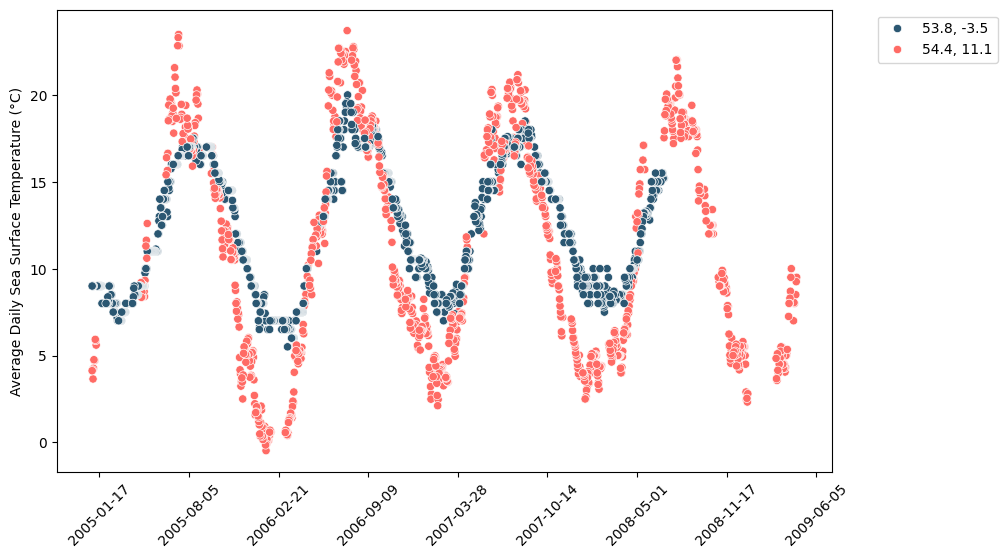

In [38]:
plt.figure(figsize=(10, 6))  # Adjust size if needed

sns.scatterplot(data=example[:-1], y='avg_sea_surface_temp', x='timestamp', hue='Lat, Long', palette=[blue, red])

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust number of xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

plt.show()

## Manipulations

ICOADS unfortunately does not impute the null rows with a timestamp for data that wasn't recorded. We'll need to construct the timestamps ourselves and join back what data we have. The Ultimate goal is to interpolate the missing values (as these variables clearly follow a precise pattern). Additionally, we want to cut down the time window, as longer sequences will introduce vanishing gradient issues

In [39]:
subset['timestamp'] = pd.to_datetime(subset[['year', 'month', 'day']])
subset['lat, long'] = subset['latitude'].astype(str) + ', ' + subset['longitude'].astype(str)
subset.drop(columns=['avg_wetbulb_temperature'], inplace=True)

In [40]:
subset.head()

,year,month,day,latitude,longitude,avg_air_temperature,avg_sea_surface_temp,timestamp,"lat, long"
0,2005,1,31,28.8,-15.6,15.5,18.0,2005-01-31,"28.8, -15.6"
1,2005,1,31,23.8,-81.0,21.1,23.3,2005-01-31,"23.8, -81.0"
2,2005,1,31,-19.6,4.6,23.3,24.3,2005-01-31,"-19.6, 4.6"
3,2005,1,31,-11.7,174.9,27.6,30.0,2005-01-31,"-11.7, 174.9"
4,2005,1,31,44.5,-149.0,11.8,10.3,2005-01-31,"44.5, -149.0"


In [41]:
locations = subset[(subset['year'] == 2015) & subset['lat, long'].isin(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])]

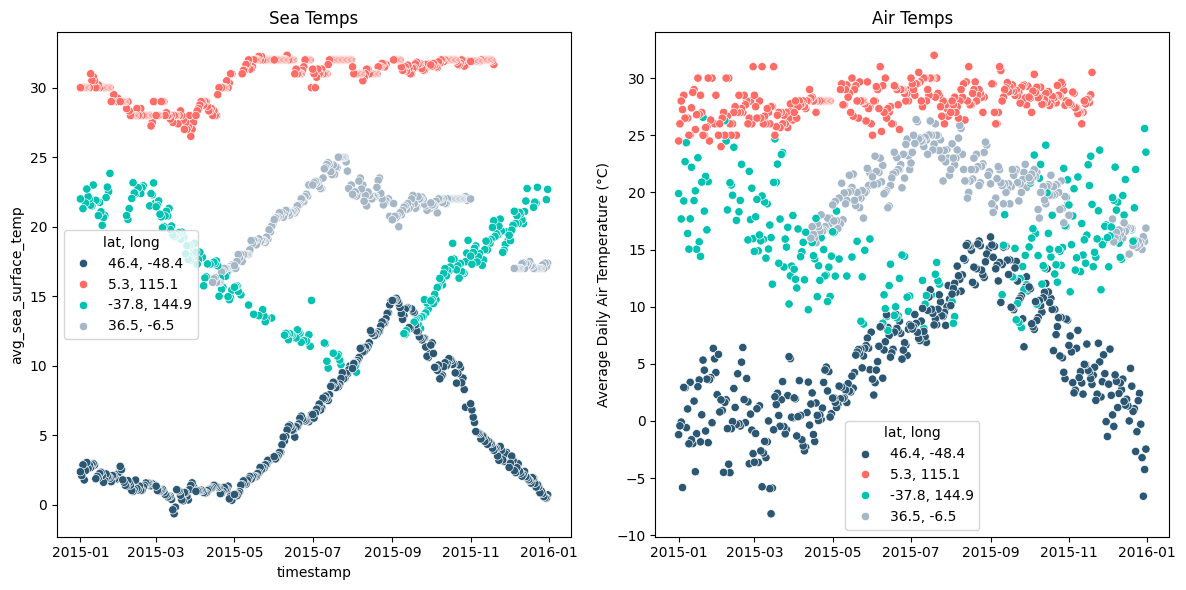

In [43]:
gray = '#bac8d3'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=locations, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0], palette=[blue, red, green, gray])
ax[0].set_title('Sea Temps')

plt.ylabel('Average Daily Sea Surface Temperature (°C)')
plt.xlabel('')

sns.scatterplot(data=locations, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[1], palette=[blue, red, green, gray])
ax[1].set_title('Air Temps')

plt.ylabel('Average Daily Air Temperature (°C)')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [44]:
def build(locs):
    master = pd.DataFrame(columns=['timestamp', 'lat, long'])
    
    for loc in locs:
        loc_df = pd.DataFrame(columns=['timestamp', 'lat, long'])
        loc_df['timestamp'] = pd.date_range(start='1-1-2015', end='12-31-2015', freq='D')
        loc_df['lat, long'] = loc
        master = pd.concat([master, loc_df])
    
    return master

locs = build(['46.4, -48.4', '5.3, 115.1', '-37.8, 144.9', '36.5, -6.5'])
final_df = locs.merge(locations.drop(columns=['year', 'month', 'day', 'latitude', 'longitude']), on=['timestamp', 'lat, long'], how='outer')

/var/folders/x3/42y9jxy964lg3yyk_9zhss280000gn/T/ipykernel_71047/3749615448.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master = pd.concat([master, loc_df])


In [45]:
final_df

,timestamp,"lat, long",avg_air_temperature,avg_sea_surface_temp
0,2015-01-01,"-37.8, 144.9",19.900000,22.000000
1,2015-01-01,"36.5, -6.5",NaN,NaN
2,2015-01-01,"46.4, -48.4",-1.200000,2.375000
3,2015-01-01,"5.3, 115.1",24.500000,30.000000
4,2015-01-02,"-37.8, 144.9",NaN,NaN
...,...,...,...,...
1455,2015-12-30,"5.3, 115.1",NaN,NaN
1456,2015-12-31,"-37.8, 144.9",23.521429,22.688235
1457,2015-12-31,"36.5, -6.5",16.875000,17.375000
1458,2015-12-31,"46.4, -48.4",-2.462500,0.712500


In [46]:
loc1 = final_df[final_df['lat, long'] == '46.4, -48.4']     # already full
loc2 = final_df[final_df['lat, long'] == '5.3, 115.1']      # missing 59   
loc3 = final_df[final_df['lat, long'] == '-37.8, 144.9']    # missing 134
loc4 = final_df[final_df['lat, long'] == '36.5, -6.5']      # missing 136 (and at beginning, need to inverse)

In [47]:
def interp(df):
    df['sea_interp'] = df['avg_sea_surface_temp'].interpolate(method='polynomial', order=1)
    df['air_interp'] = df['avg_air_temperature'].interpolate(method='polynomial', order=1)

    df['full_sea'] = df['sea_interp'].fillna(method='bfill').fillna(method='ffill')
    df['full_air'] = df['air_interp'].fillna(method='bfill').fillna(method='ffill')
    
    return df

In [48]:
locations = [loc1, loc2, loc3, loc4]

data = pd.DataFrame(columns=final_df.columns)
data['sea_interp'] = np.nan
data['air_interp'] = np.nan

for location in locations:
    location = interp(location)
    data = pd.concat([data, location])

/var/folders/x3/42y9jxy964lg3yyk_9zhss280000gn/T/ipykernel_71047/3234944528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sea_interp'] = df['avg_sea_surface_temp'].interpolate(method='polynomial', order=1)
/var/folders/x3/42y9jxy964lg3yyk_9zhss280000gn/T/ipykernel_71047/3234944528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['air_interp'] = df['avg_air_temperature'].interpolate(method='polynomial', order=1)
/var/folders/x3/42y9jxy964lg3yyk_9zhss280000gn/T/ipykernel_71047/3234944528.py:5:

In [19]:
data

,timestamp,"lat, long",avg_air_temperature,avg_sea_surface_temp,sea_interp,air_interp,full_sea,full_air
2,2015-01-01,"46.4, -48.4",-1.200000,2.375000,2.375000,-1.200000,2.375000,-1.200000
6,2015-01-02,"46.4, -48.4",-0.428571,2.100000,2.100000,-0.428571,2.100000,-0.428571
10,2015-01-03,"46.4, -48.4",-0.100000,2.871429,2.871429,-0.100000,2.871429,-0.100000
14,2015-01-04,"46.4, -48.4",-5.828571,1.785714,1.785714,-5.828571,1.785714,-5.828571
18,2015-01-05,"46.4, -48.4",2.937500,2.462500,2.462500,2.937500,2.462500,2.937500
...,...,...,...,...,...,...,...,...
1441,2015-12-27,"36.5, -6.5",15.625000,17.250000,17.250000,15.625000,17.250000,15.625000
1445,2015-12-28,"36.5, -6.5",15.000000,17.000000,17.000000,15.000000,17.000000,15.000000
1449,2015-12-29,"36.5, -6.5",16.125000,17.375000,17.375000,16.125000,17.375000,16.125000
1453,2015-12-30,"36.5, -6.5",15.714286,17.142857,17.142857,15.714286,17.142857,15.714286


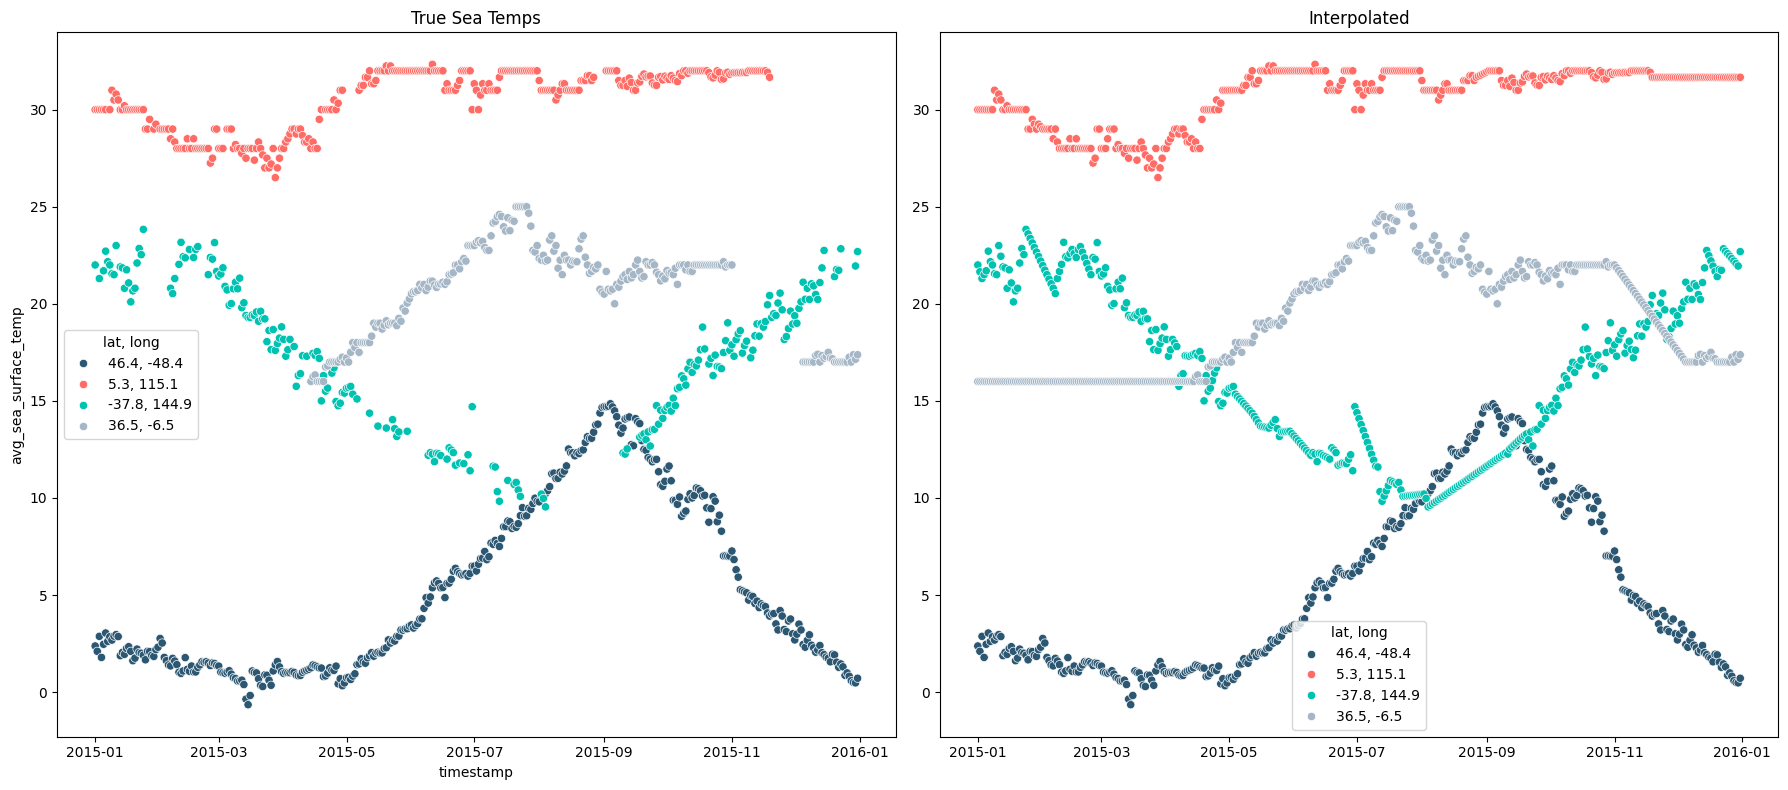

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_sea_surface_temp', hue='lat, long', ax=ax[0], palette=[blue, red, green, gray])
ax[0].set_title('True Sea Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_sea', hue='lat, long', ax=ax[1], palette=[blue, red, green, gray])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

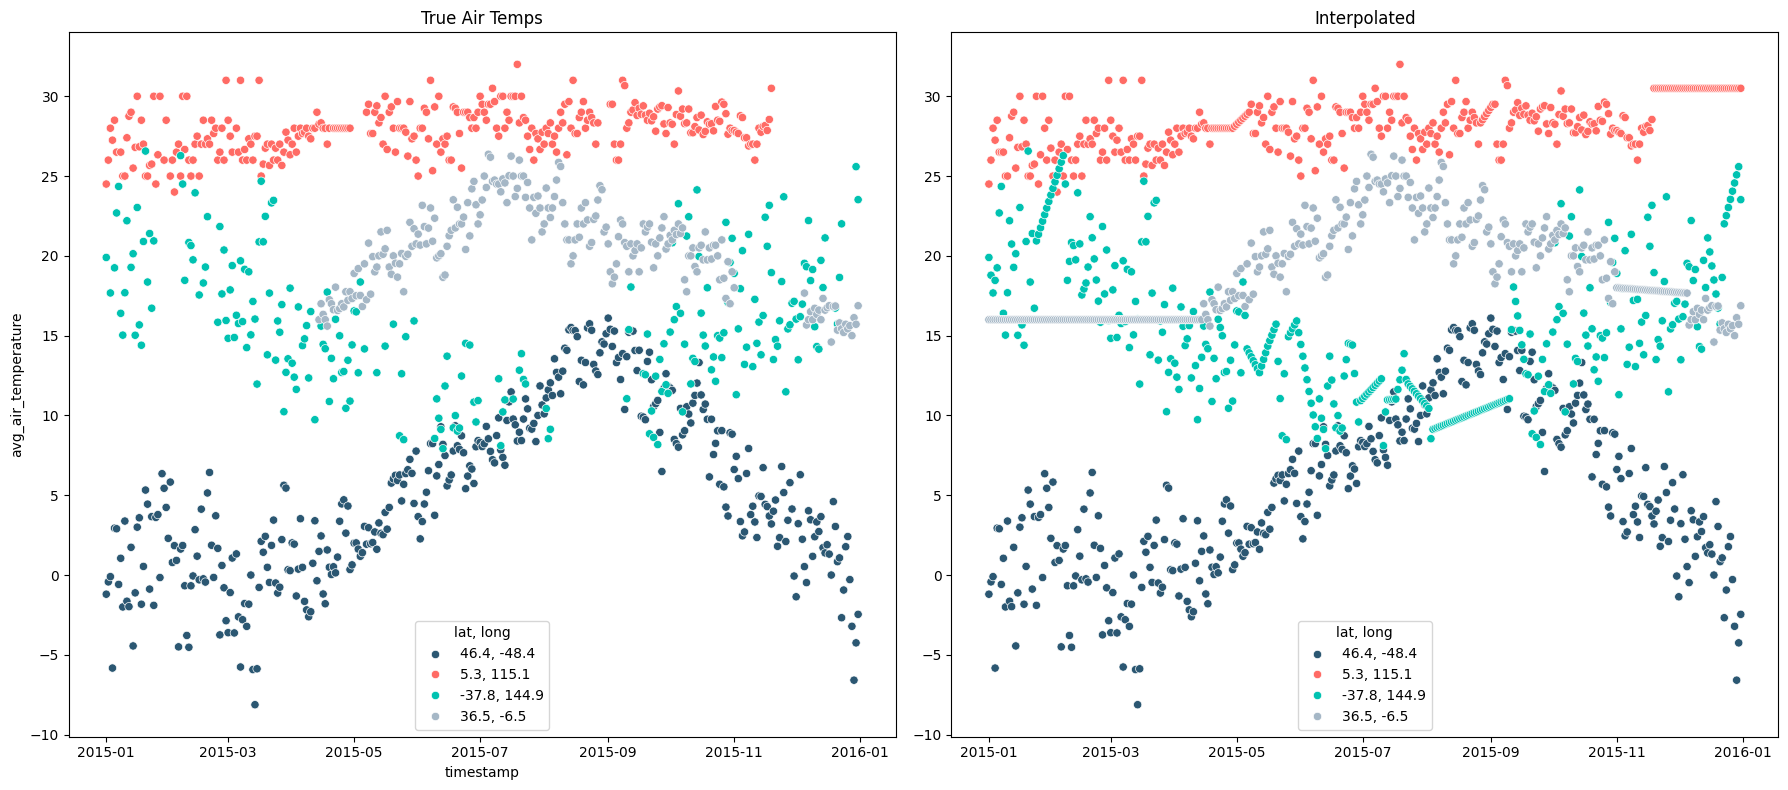

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.scatterplot(data=data, x='timestamp', y='avg_air_temperature', hue='lat, long', ax=ax[0], palette=[blue, red, green, gray])
ax[0].set_title('True Air Temps')

plt.ylabel('')
plt.xlabel('')

sns.scatterplot(data=data, x='timestamp', y='full_air', hue='lat, long', ax=ax[1], palette=[blue, red, green, gray])
ax[1].set_title('Interpolated')

plt.ylabel('')
plt.xlabel('')

plt.tight_layout()
plt.show()

In [24]:
data.to_pickle('final-locs.pkl')

# Predicting Average Global Sea Temperature

# Multi-Locational Predictive Models

In [51]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import torch.nn as nn

df = pd.read_pickle('final-locs.pkl')

## Splitting

In [52]:
sub = df[['full_sea', 'lat, long', 'timestamp']]
sub.set_index('timestamp')

df_new = {}
for i in sub['lat, long'].unique():
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = sub[sub['lat, long'] == i].iloc[:int(len(sub[sub['lat, long'] == i])*0.8)], sub[sub['lat, long'] == i].iloc[int(len(sub[sub['lat, long'] == i])*0.8):]

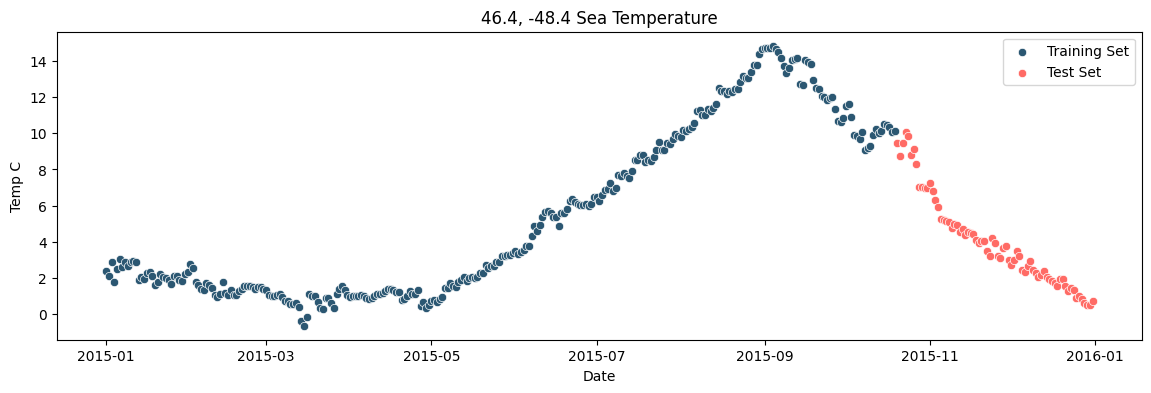

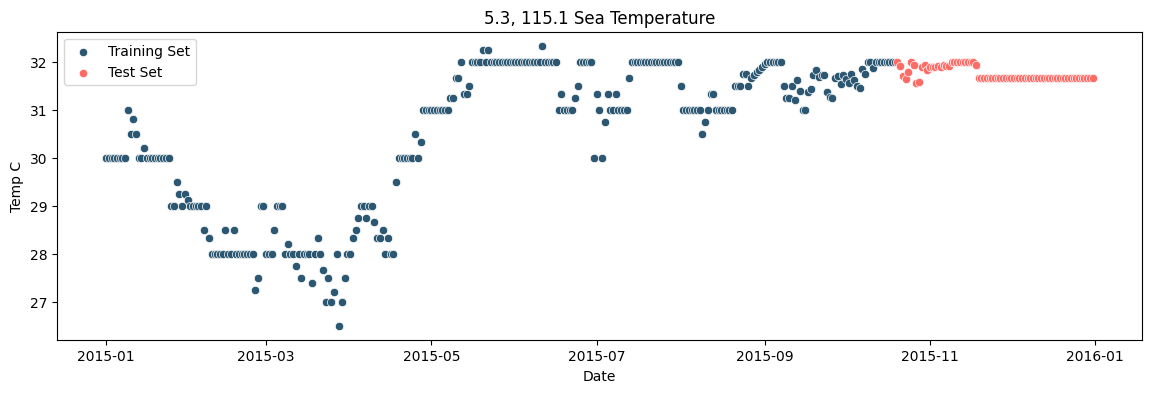

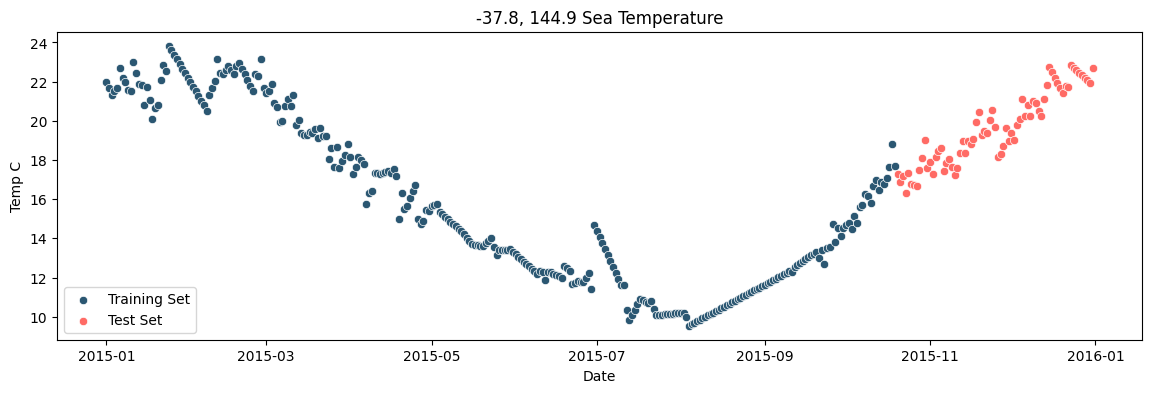

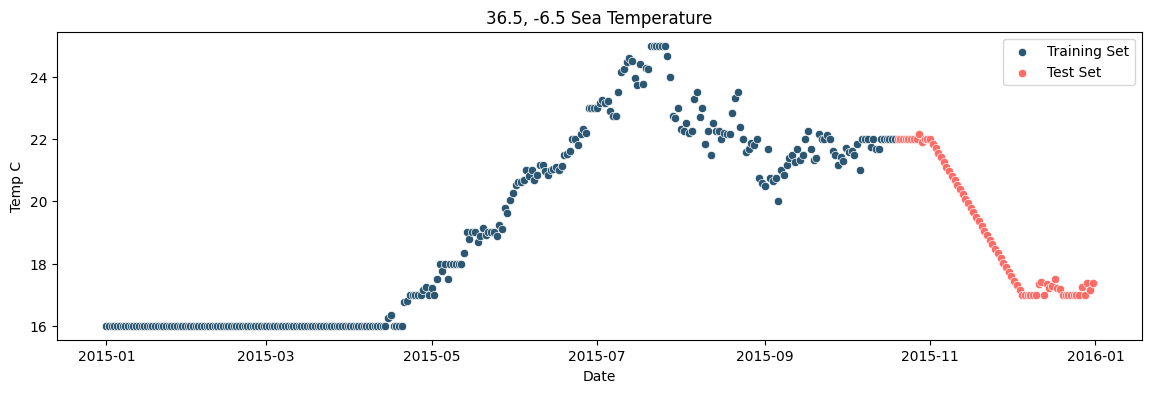

In [53]:
import seaborn as sns

for i in df['lat, long'].unique():
    plt.figure(figsize=(14,4))
    sns.scatterplot(y=df_new[i]["Train"]['full_sea'], x=df_new[i]['Train']['timestamp'], color=blue)
    sns.scatterplot(y=df_new[i]["Test"]['full_sea'], x=df_new[i]['Test']['timestamp'], color=red)
    plt.ylabel("Temp C")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Sea Temperature")

## Preprocessing

In [54]:
from sklearn.preprocessing import MinMaxScaler

transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(df['lat, long'].unique()):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"]['full_sea'])
    a1 = np.array(df_new[i]["Test"]['full_sea'])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [55]:
def dataload(seq):
    trainset = {}
    testset = {}

    for j in df['lat, long'].unique():
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(seq, 292):
            X_train.append(transform_train[j][i-seq:i,0])
            y_train.append(transform_train[j][i,0])
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        trainset[j]["y"] = y_train
        
        testset[j] = {}
        X_test = []
        y_test = []    
        
        for i in range(seq, 73):
            X_test.append(transform_test[j][i-seq:i,0])
            y_test.append(transform_test[j][i,0])
        
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
        testset[j]["y"] = y_test

    return trainset, testset

In [57]:
trainset, testset = dataload(7)

In [58]:
arr_buff = []

for i in df['lat, long'].unique():
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=df['lat, long'].unique())

,X_train,y_train,X_test,y_test
"46.4, -48.4","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"5.3, 115.1","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"-37.8, 144.9","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"36.5, -6.5","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"


## Defining Models

In [59]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the RNN
num_layers = 2  # Number of RNN layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
rnn = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(rnn)

RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [60]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
lstm = LSTM(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(lstm)

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


## Training

In [63]:
import torch

In [64]:
def train(model, eval=str):
    preds = {}

    # Define the loss function
    if eval == "L1":
        criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
    
    if eval == "MSE":
        criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trains = []
    for i in df['lat, long'].unique():
        # Convert numpy arrays to PyTorch tensors
        X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
        y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
        
        num_epochs = 500
        # Training loop
        for epoch in range(num_epochs):
            # Forward pass
            outputs = model(X_train)
            
            # Calculate loss
            loss = criterion(outputs, y_train.reshape(-1, 1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

        # Evaluation
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            outputs = model(X_train)
            
            # Reshape the target data to match the shape of the model's output
            y_train_reshaped = y_train.reshape(-1, 1)
            
            loss_train = criterion(outputs, y_train_reshaped)
            trains.append(loss_train.item())
            print(f'\nMAE Loss on Training Set for {i}: {loss_train.item():.4f}')
            preds[i] = scaler[i].inverse_transform(outputs.numpy())

            # Calculate training accuracy
            train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

        
    tests = []    
    for i, j in zip(df['lat, long'].unique(), trains):
        # Evaluate on test set
        X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
        y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
        
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            test_outputs = model(X_test)
            test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
            loss_test = criterion(test_outputs, y_test.reshape(-1, 1))
            preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

        # Print progress
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Training {eval}: {j:.4f}, Test {eval}: {loss_test:.4f}')
        tests.append(loss_test.item())
        # model.train()  # Set the model back to training mode
    
    return preds, trains, tests

In [66]:
rnn_preds, rnn_train_mse, rnn_test_mse = train(rnn, eval="MSE")

Epoch 1, Loss: 0.0004951851442456245
Epoch 2, Loss: 0.002934302669018507
Epoch 3, Loss: 0.0010376711143180728
Epoch 4, Loss: 0.0023156306706368923
Epoch 5, Loss: 0.0012058591237291694
Epoch 6, Loss: 0.0004742849268950522
Epoch 7, Loss: 0.0011000785743817687
Epoch 8, Loss: 0.0014825401594862342
Epoch 9, Loss: 0.001041881274431944
Epoch 10, Loss: 0.0006399230333045125
Epoch 11, Loss: 0.0007953988970257342
Epoch 12, Loss: 0.0010729560162872076
Epoch 13, Loss: 0.0009483281173743308
Epoch 14, Loss: 0.0005949235637672246
Epoch 15, Loss: 0.00047779740998521447
Epoch 16, Loss: 0.0006690131849609315
Epoch 17, Loss: 0.0008063581190072
Epoch 18, Loss: 0.0006882685702294111
Epoch 19, Loss: 0.0005265105282887816
Epoch 20, Loss: 0.0005543761071749032
Epoch 21, Loss: 0.0006821776041761041
Epoch 22, Loss: 0.0006806877790950239
Epoch 23, Loss: 0.0005468802992254496
Epoch 24, Loss: 0.00046811214997433126
Epoch 25, Loss: 0.0005221955943852663
Epoch 26, Loss: 0.0005882708937861025
Epoch 27, Loss: 0.000558

In [73]:
lstm_preds, lstm_train_mse, lstm_test_mse = train(lstm, eval="MSE")

Epoch 1, Loss: 0.0005313614965416491
Epoch 2, Loss: 0.004424257203936577
Epoch 3, Loss: 0.0005087531753815711
Epoch 4, Loss: 0.0024650401901453733
Epoch 5, Loss: 0.002871379954740405
Epoch 6, Loss: 0.0012713620672002435
Epoch 7, Loss: 0.0004694711824413389
Epoch 8, Loss: 0.0011242249747738242
Epoch 9, Loss: 0.0018091690726578236
Epoch 10, Loss: 0.0015430478379130363
Epoch 11, Loss: 0.0008215766283683479
Epoch 12, Loss: 0.0004920291248708963
Epoch 13, Loss: 0.0007786278729327023
Epoch 14, Loss: 0.001169749186374247
Epoch 15, Loss: 0.0011468167649582028
Epoch 16, Loss: 0.0007775998674333096
Epoch 17, Loss: 0.0004897147882729769
Epoch 18, Loss: 0.000541222223546356
Epoch 19, Loss: 0.000780888251028955
Epoch 20, Loss: 0.0008825575932860374
Epoch 21, Loss: 0.0007376341964118183
Epoch 22, Loss: 0.0005286362720653415
Epoch 23, Loss: 0.0004767056670971215
Epoch 24, Loss: 0.0005952681531198323
Epoch 25, Loss: 0.0007049589767120779
Epoch 26, Loss: 0.0006678569479845464
Epoch 27, Loss: 0.00053799

## Visualizing Results

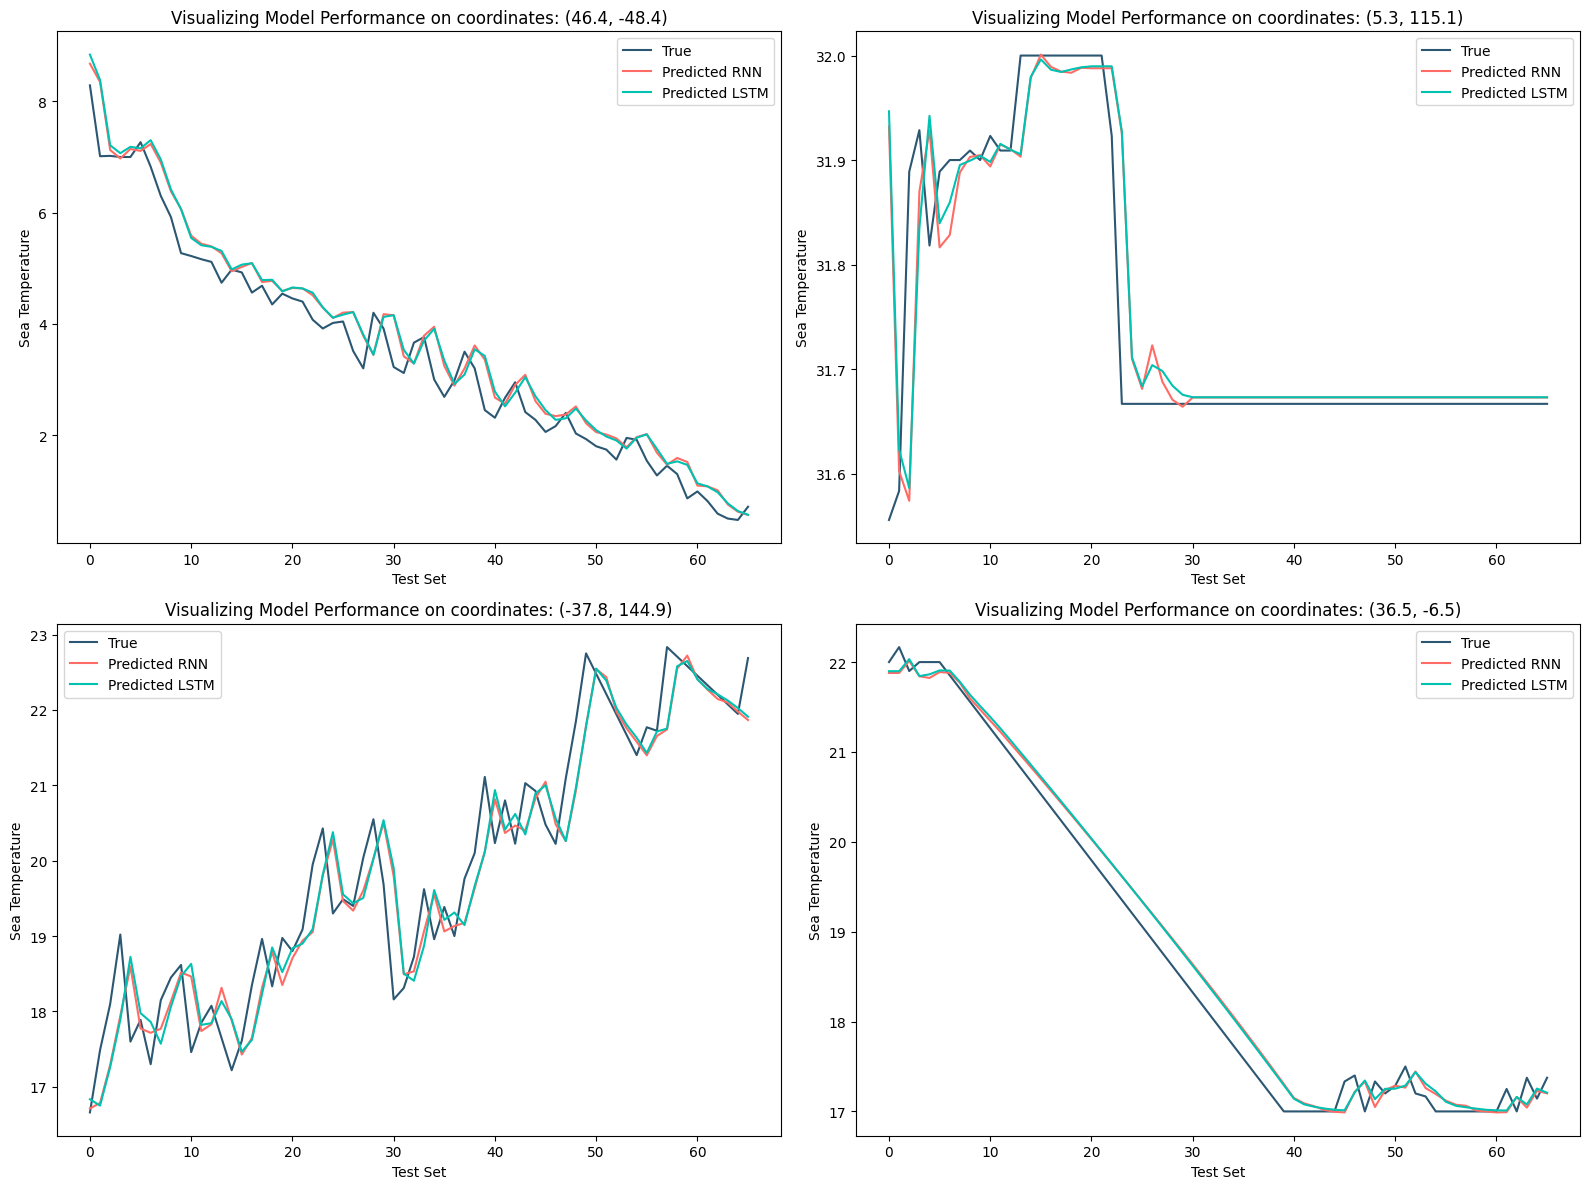

In [70]:
# Define unique coordinates
unique_coords = df['lat, long'].unique()

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over unique coordinates and plot performance
for idx, coord in enumerate(unique_coords):
    y_true = scaler[coord].inverse_transform(testset[coord]["y"].reshape(-1, 1))
    y_pred_rnn = rnn_preds[coord]
    y_pred_lstm = lstm_preds[coord]
    
    ax = axs[idx]
    
    ax.set_xlabel('Test Set')
    ax.set_ylabel('Sea Temperature')
    ax.set_title(f'Visualizing Model Performance on coordinates: ({coord})')
    
    sns.lineplot(data=y_true.flatten(), label='True', ax=ax, color=blue)
    sns.lineplot(data=y_pred_rnn.flatten(), label='Predicted RNN', ax=ax, color=red)
    sns.lineplot(data=y_pred_lstm.flatten(), label='Predicted LSTM', ax=ax, color=green)

# Adjust layout
plt.tight_layout()
plt.show()

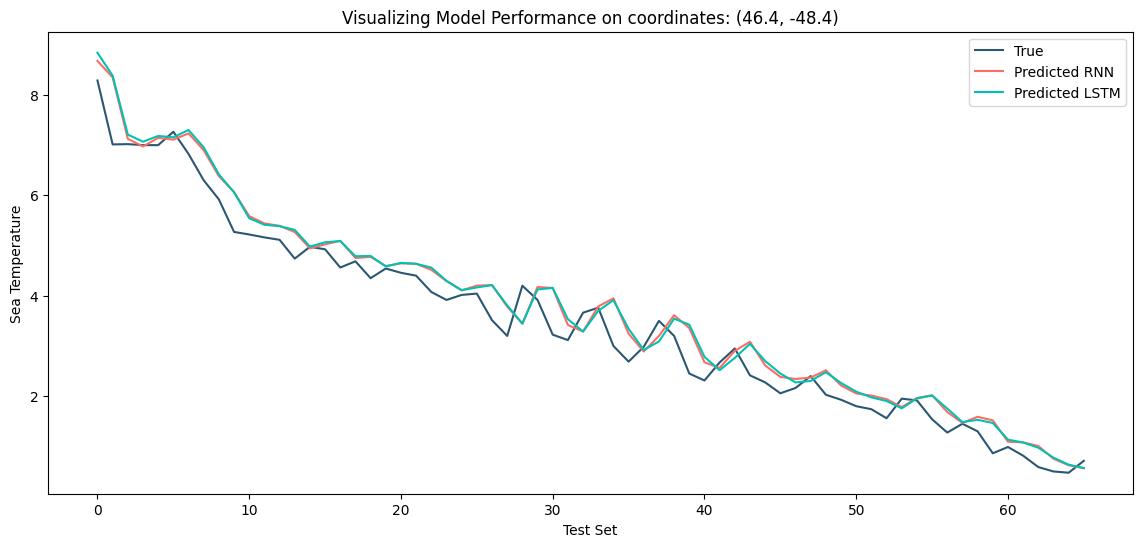

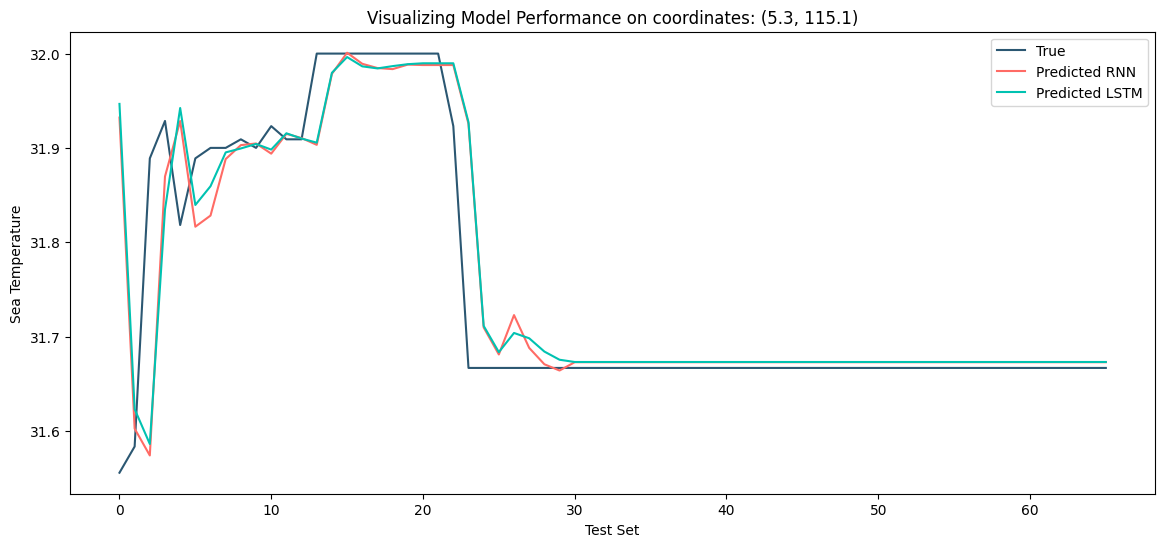

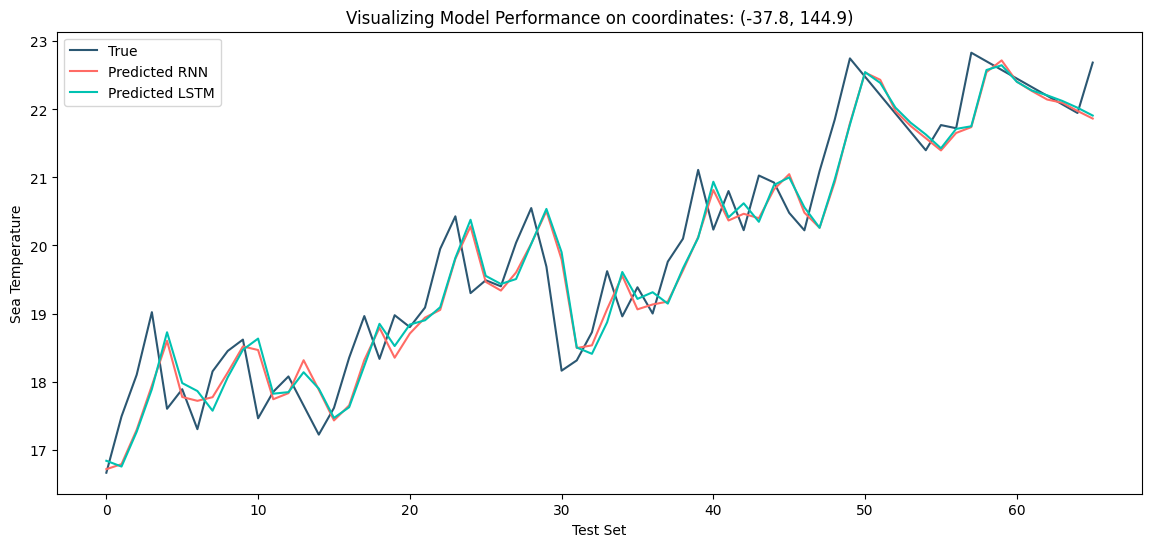

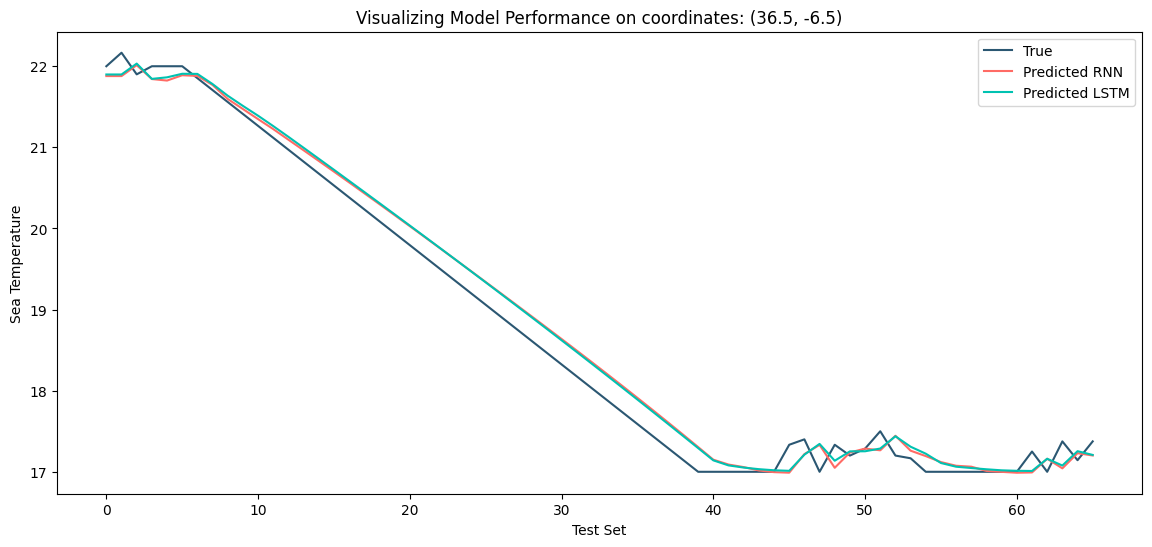

In [68]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred_rnn = rnn_preds[i]
    y_pred_lstm = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), label='True', color=blue)
    sns.lineplot(y_pred_rnn.flatten(), label='Predicted RNN', color=red)
    sns.lineplot(y_pred_lstm.flatten(), label='Predicted LSTM', color=green)
    plt.show()

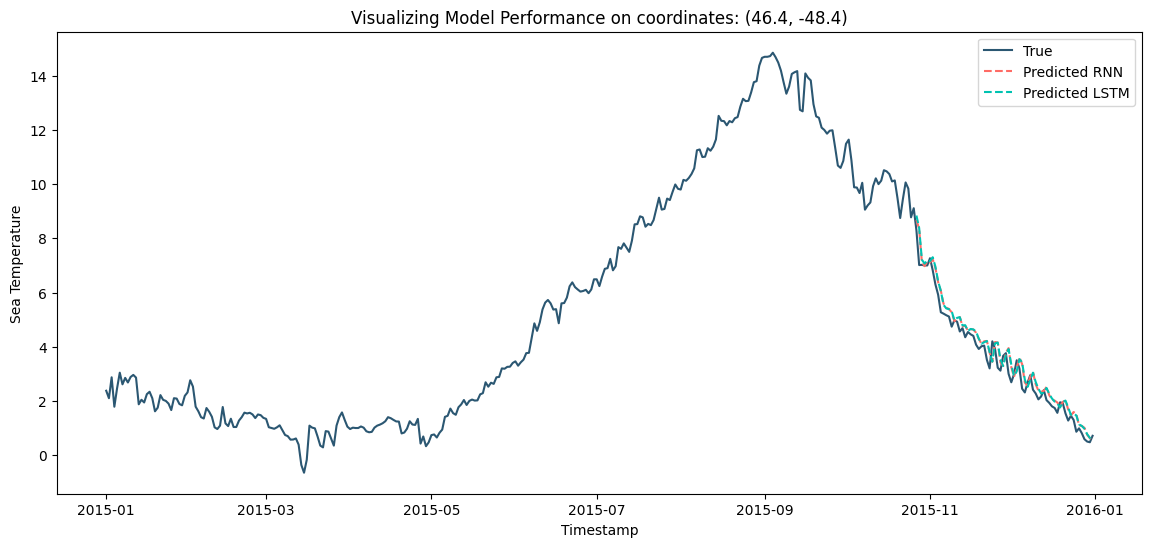

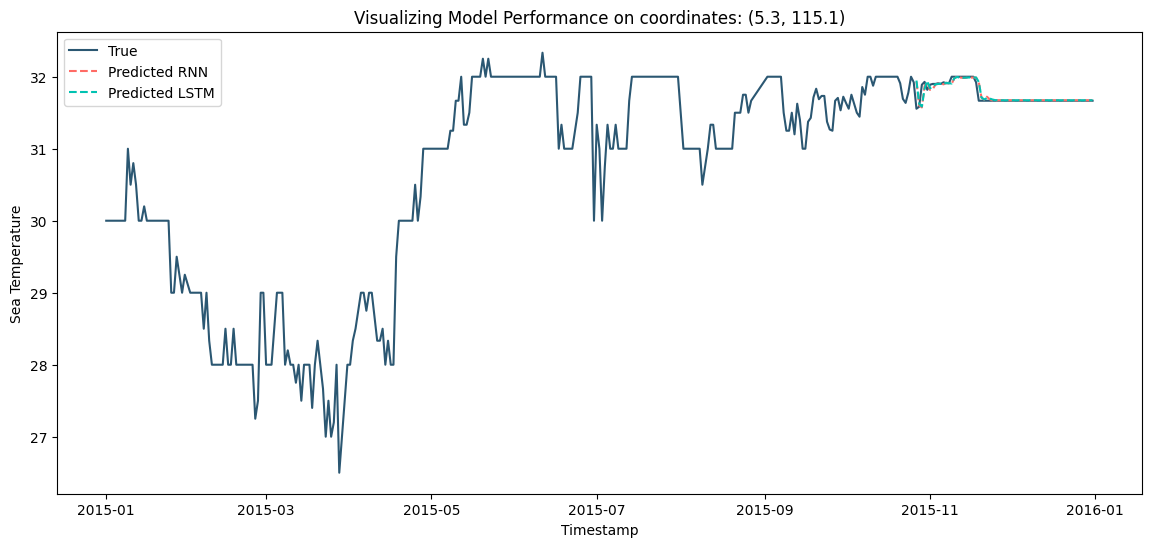

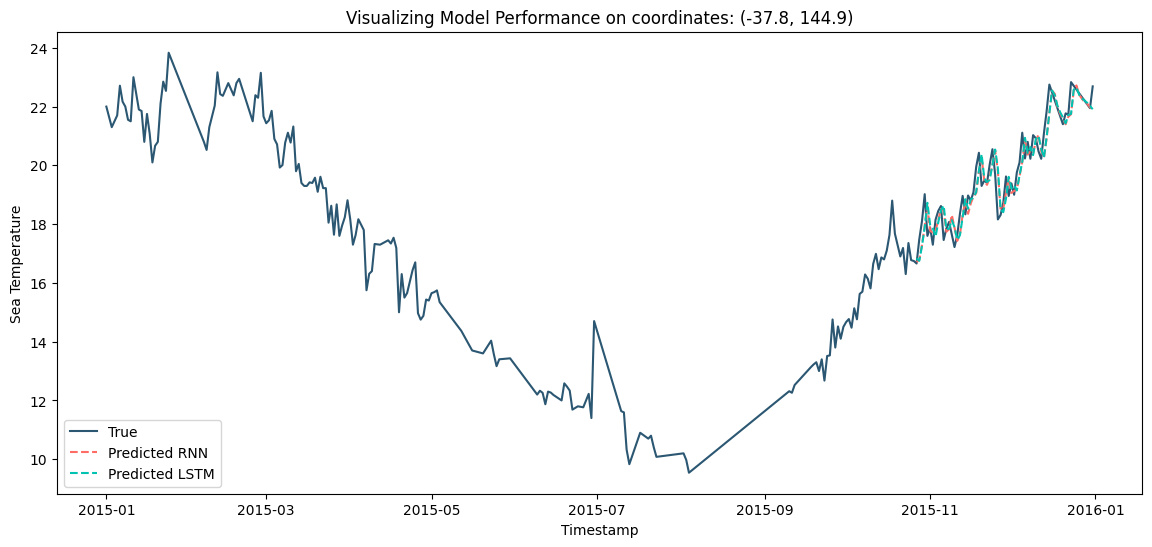

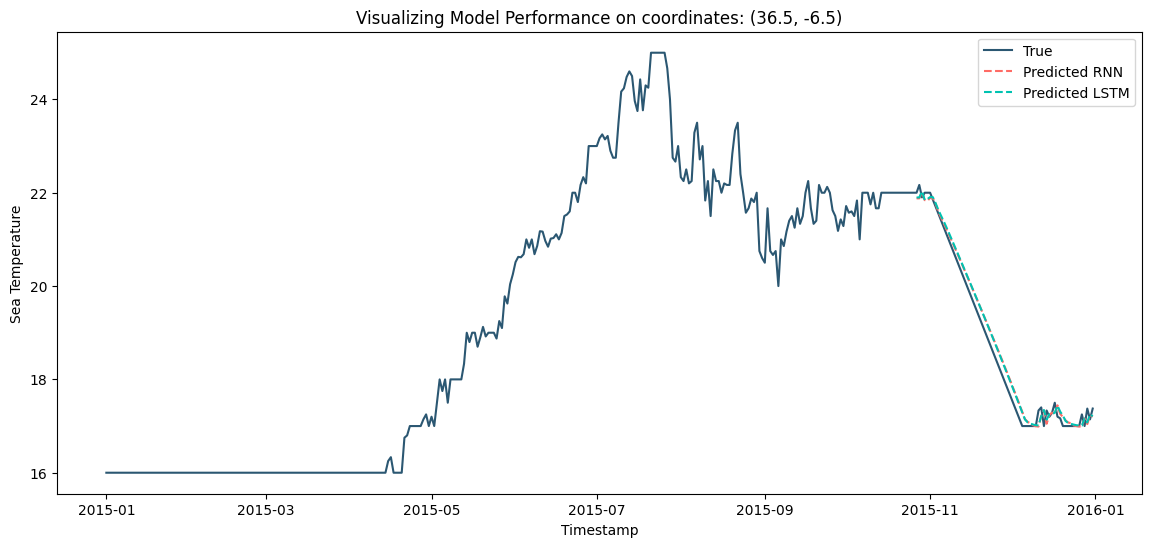

In [69]:
# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    
    temps_rnn = pd.DataFrame({'timestamp': adj, 'temps': temps})

    temps = lstm_preds[i].reshape(-1)
    temps_lstm = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color=blue)
    sns.lineplot(data=temps_rnn, x='timestamp', y='temps', label='Predicted RNN', color=red, linestyle='--')
    sns.lineplot(data=temps_lstm, x='timestamp', y='temps', label='Predicted LSTM', color=green, linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()

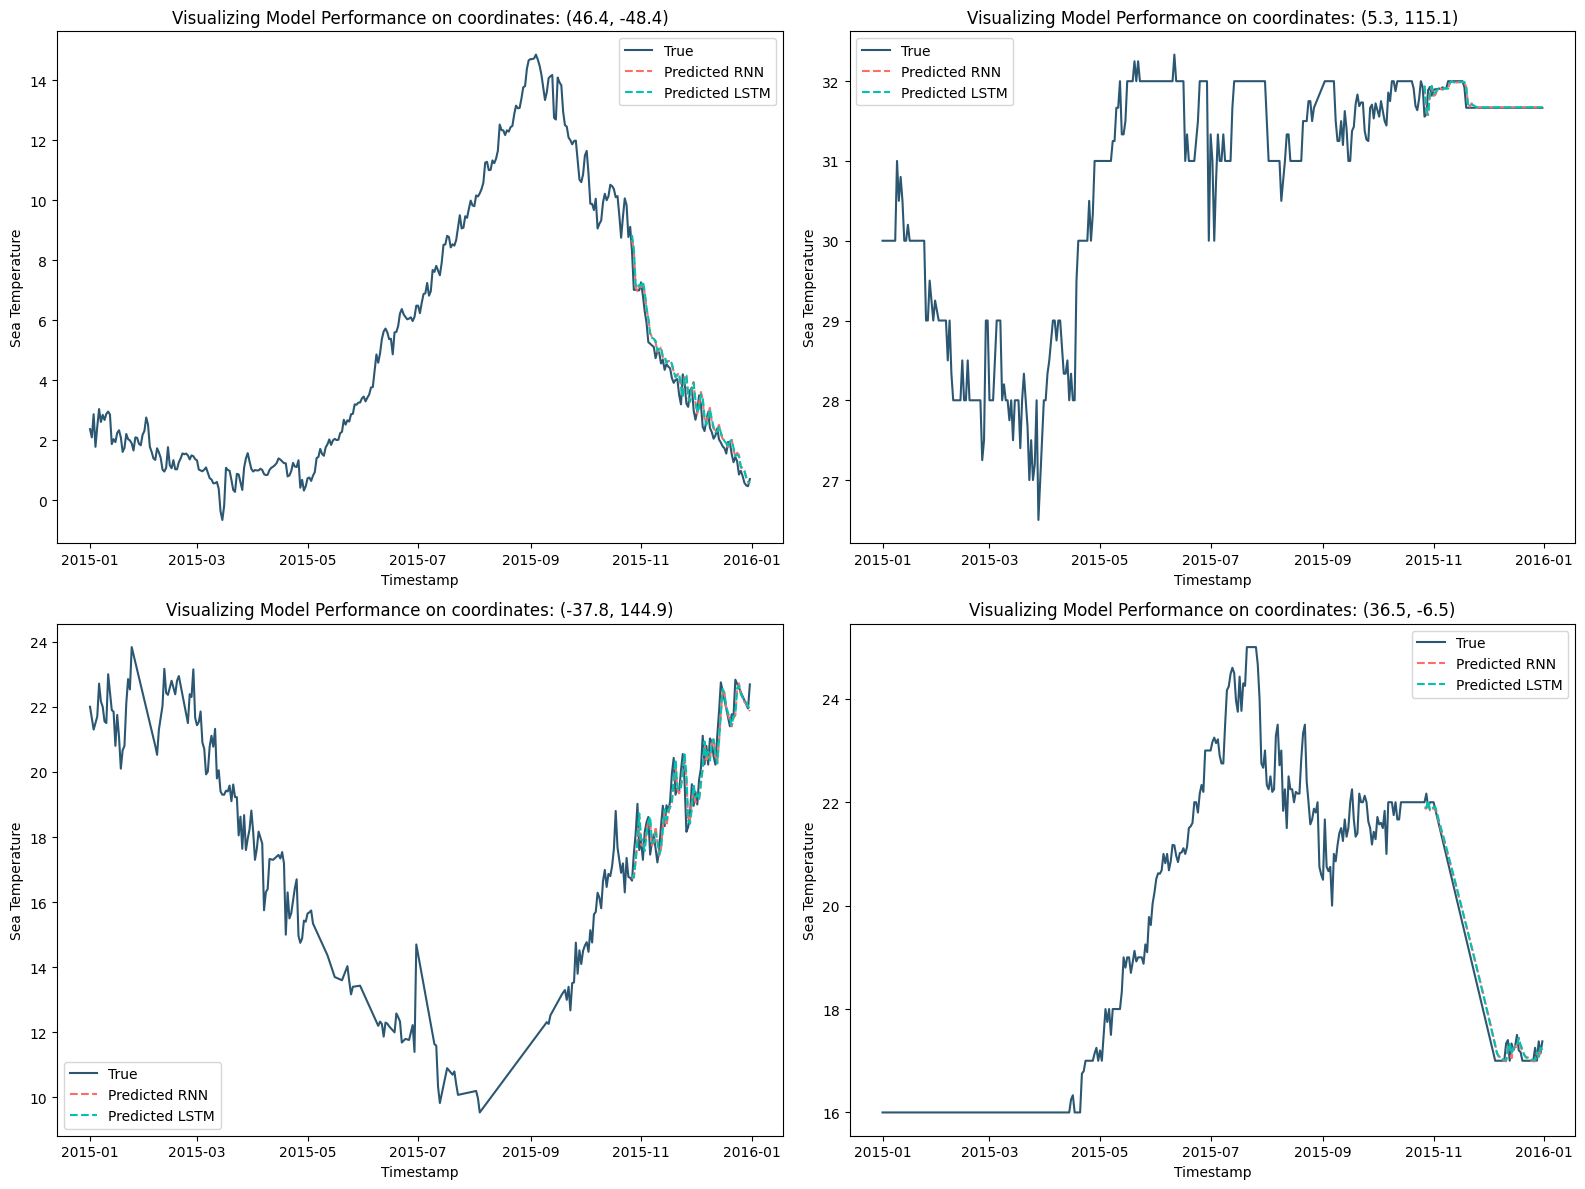

In [72]:
# Define timestamp
timestamp = df['timestamp'].unique()

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over unique coordinates and plot performance
for idx, coord in enumerate(df['lat, long'].unique()):
    temps_rnn = rnn_preds[coord].reshape(-1)
    temps_lstm = lstm_preds[coord].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[coord]):]
    
    temps_rnn_df = pd.DataFrame({'timestamp': adj, 'temps': temps_rnn})
    temps_lstm_df = pd.DataFrame({'timestamp': adj, 'temps': temps_lstm})
    
    sub = df[df['lat, long'] == coord]
    
    ax = axs[idx]
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color=blue, ax=ax)
    
    # Plot predicted sea temperature for RNN
    sns.lineplot(data=temps_rnn_df, x='timestamp', y='temps', label='Predicted RNN', color=red, linestyle='--', ax=ax)
    
    # Plot predicted sea temperature for LSTM
    sns.lineplot(data=temps_lstm_df, x='timestamp', y='temps', label='Predicted LSTM', color=green, linestyle='--', ax=ax)
    
    # Add labels and legend
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Sea Temperature')
    ax.set_title(f'Performance on coordinates: ({coord})')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [74]:
pd.DataFrame(columns=['RNN Training Loss', 'RNN Test Loss', 'LSTM Training Loss', 'LSTM Test Loss'], data=[rnn_train_mse, rnn_test_mse, lstm_train_mse, lstm_test_mse], index=unique_coords)

,RNN Training Loss,RNN Test Loss,LSTM Training Loss,LSTM Test Loss
"46.4, -48.4",0.000401,0.003279,0.001221,0.001125
"5.3, 115.1",0.002207,0.027952,0.008479,0.001644
"-37.8, 144.9",0.000411,0.003340,0.001237,0.001123
"36.5, -6.5",0.002416,0.026903,0.008112,0.002026
